# LSTM Regression

## Liabraries importing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import callbacks

## Load data

In [2]:
df = pd.read_csv("C:/Users/DELL-PC/Desktop/PGDM/Term 5/DL & ML/End Term Project/household_daily.csv")
# Convert datetime to pandas datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
# Set datetime as the index
df.set_index('datetime', inplace=True)

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [5]:
# Define features and target
features = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_4']
target = 'Global_active_power'

In [6]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [7]:
# Prepare the data for LSTM
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(n_timesteps, len(data)):
        X.append(data[i-n_timesteps:i, :-1])  # All features except the target
        y.append(data[i, -1])  # The target is the last column
    return np.array(X), np.array(y)

In [8]:
n_timesteps = 5
X, y = create_sequences(scaled_data, n_timesteps)

In [9]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [29]:
 print('Dimention of X_train (3D):', X_train.shape)
 print('Dimention of y_train (1D):', y_train.shape)
 print('Dimention of X_test (3D):', X_test.shape)
 print('Dimention of y_test (1D):', y_test.shape)

Dimention of X_train (3D): (1149, 5, 7)
Dimention of y_train (1D): (1149,)
Dimention of X_test (3D): (288, 5, 7)
Dimention of y_test (1D): (288,)


## Model Building 

In [24]:
# Function to build LSTM model with variable activation functions
def build_lstm_model(activation_lstm='tanh', activation_dense='linear'):
    model = Sequential()
    # LSTM layers with variable activation functions
    model.add(LSTM(units=100, activation=activation_lstm, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(units=90, activation=activation_lstm, return_sequences=False))
    model.add(Dropout(0.2))
    # Dense output layer with variable activation function
    model.add(Dense(units=1, activation=activation_dense))
    
    # Compile the model
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
    return model

In [27]:
# Define different activation functions to test
activation_functions = ['relu', 'tanh', 'selu', 'sigmoid', 'linear']
activation_results = {}

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train and evaluate models with different activation functions
for activation in activation_functions:
    print(f"Training with activation function: {activation}")
    
    # Build the model with the current activation function
    model = build_lstm_model(activation_lstm=activation, activation_dense='linear')  # Keep output layer linear
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate on test set
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store the performance metrics
    activation_results[activation] = {'mse': mse, 'mae': mae}

# Compare the results and select the best model based on lowest MAE
best_activation = min(activation_results, key=lambda x: activation_results[x]['mae'])

Training with activation function: relu
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Training with activation function: tanh


C:\Users\DELL-PC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Training with activation function: selu


C:\Users\DELL-PC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Training with activation function: sigmoid


C:\Users\DELL-PC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training with activation function: linear


C:\Users\DELL-PC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [28]:
# Print the results
print("\nActivation Function Comparison:")
for activation, metrics in activation_results.items():
    print(f"{activation}: MSE = {metrics['mse']:.4f}, MAE = {metrics['mae']:.4f}")

print(f"\nBest activation function based on MAE: {best_activation}")


Activation Function Comparison:
relu: MSE = 0.0060, MAE = 0.0604
tanh: MSE = 0.0091, MAE = 0.0783
selu: MSE = 0.0077, MAE = 0.0687
sigmoid: MSE = 0.0276, MAE = 0.1425
linear: MSE = 0.0055, MAE = 0.0560

Best activation function based on MAE: linear


In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=90, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

C:\Users\DELL-PC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 5, 100)              │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 90)                  │          68,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              91 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,051 (437.70 KB)

 Trainable params: 112,051 (437.70 KB)

 Non-trainable params: 0 (0.00 B)

new change

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model (assuming the model architecture has been defined above)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss',verbose = 1, patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=0)

# Find the epoch with the minimum validation loss
loss_epochs = np.argmin(history.history['val_loss']) + 1
print('Minimum validation loss at epoch %d' % loss_epochs)

# Find the epoch with the maximum validation accuracy (Mean Absolute Error)
accuracy_epochs = np.argmax(history.history['val_mae']) + 1
print('Maximum validation accuracy (MAE) at epoch %d' % accuracy_epochs)

# Evaluate the model on the training data
scores_train = model.evaluate(X_train, y_train, verbose=0)
# Evaluate the model on the test data
scores_test = model.evaluate(X_test, y_test, verbose=0)

# Print the metrics for the training set
for key, val in zip(model.metrics_names, scores_train):
    print("Train: %s = %.2f%%" % (key, val * 100))

# Print the metrics for the test set
for key, val in zip(model.metrics_names, scores_test):
    print("Test: %s = %.2f%%" % (key, val * 100))

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
Minimum validation loss at epoch 6
Maximum validation accuracy (MAE) at epoch 3
Train: loss = 1.03%
Train: compile_metrics = 7.64%
Test: loss = 0.60%
Test: compile_metrics = 5.93%


In [35]:
# Evaluate the model on the test set
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

In [36]:
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

Train Loss: 0.0103, Train MAE: 0.0764
Test Loss: 0.0060, Test MAE: 0.0593


In [37]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred[:10]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([0.40325344, 0.4097039 , 0.41089943, 0.40306106, 0.41661125,
       0.40540475, 0.38432452, 0.38105664, 0.38739714, 0.40173396],
      dtype=float32)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0126 - mae: 0.0825 - val_loss: 0.0079 - val_mae: 0.0706
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0120 - mae: 0.0821 - val_loss: 0.0080 - val_mae: 0.0702
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0102 - mae: 0.0740 - val_loss: 0.0098 - val_mae: 0.0802
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0122 - mae: 0.0818 - val_loss: 0.0087 - val_mae: 0.0736
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - mae: 0.0751 - val_loss: 0.0076 - val_mae: 0.0693
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0124 - mae: 0.0820 - val_loss: 0.0077 - val_mae: 0.0685
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0132 - mae: 0.0852 - val_loss: 0.0079 - val_mae: 0.0694
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0111 - mae: 0.0774 - val_loss: 0.0080 - val_mae: 0.0698
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - lo

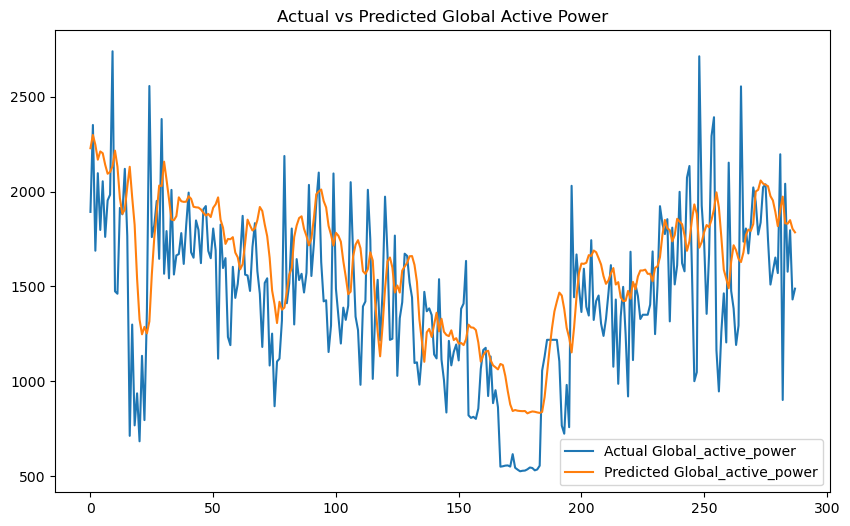

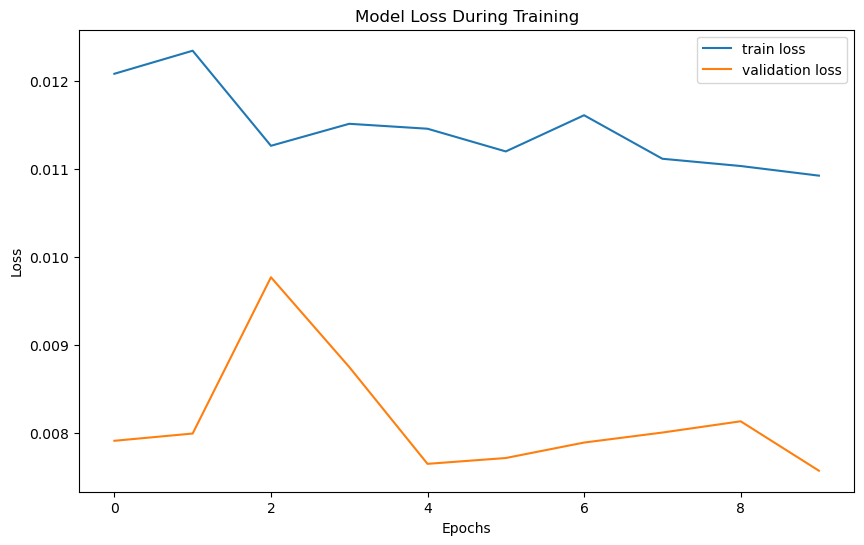

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Separate scalers for features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit the feature scaler and scale the features
scaled_features = scaler_features.fit_transform(df[features])

# Fit the target scaler and scale the target
scaled_target = scaler_target.fit_transform(df[[target]])

# Combine scaled features and target for further processing
scaled_data = np.concatenate([scaled_features, scaled_target], axis=1)

# Prepare the data for LSTM (same function as before)
X, y = create_sequences(scaled_data, n_timesteps)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model (no changes here)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

# Inverse transform the target values to get the actual values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Global_active_power')
plt.plot(y_pred_actual, label='Predicted Global_active_power')
plt.legend()
plt.title('Actual vs Predicted Global Active Power')
plt.show()

# Plot training & validation loss (no changes here)
plot_performance(history)

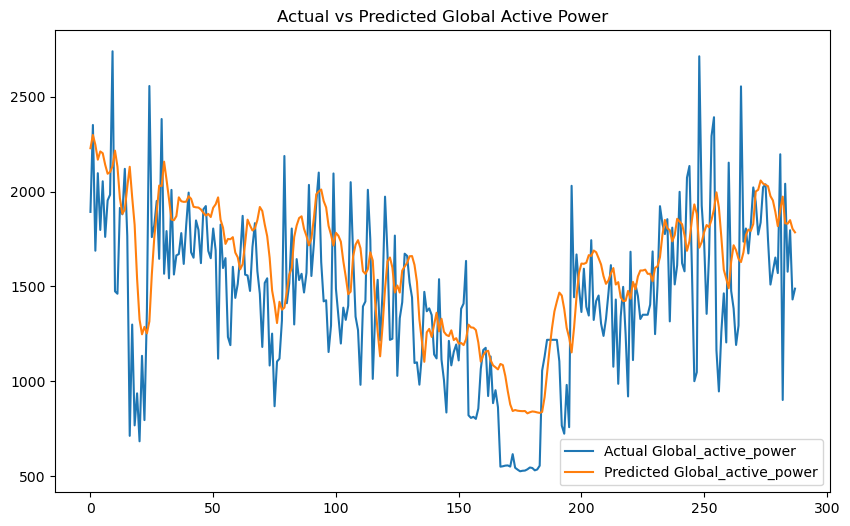

In [22]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Global_active_power')
plt.plot(y_pred_actual, label='Predicted Global_active_power')
plt.legend()
plt.title('Actual vs Predicted Global Active Power')
plt.show()

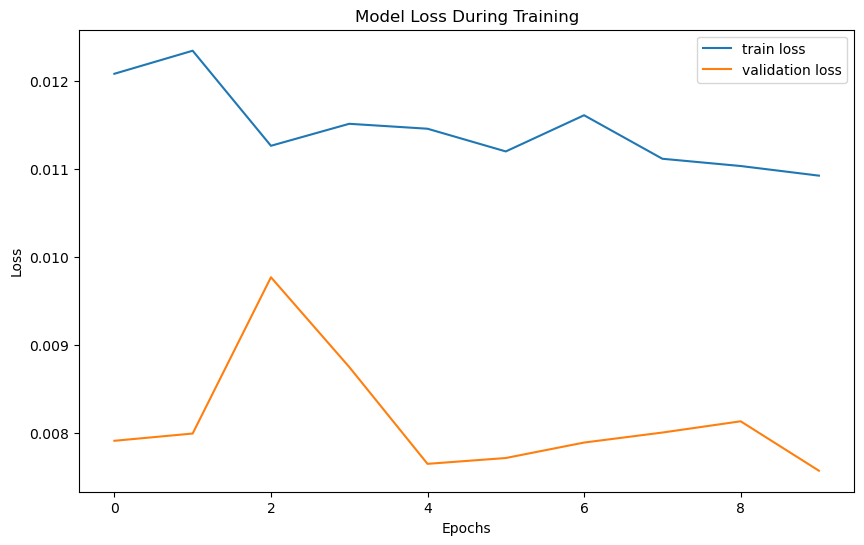

In [23]:

# Plot training & validation loss
def plot_performance(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

plot_performance(history)